# Experimental setup and description

The goal of this experiment is to show the capacity of our tool to automatically transform a real and complex execution trace into a simulator, allowing to perform what-if analysis.

Currently we only validate our system for a CPU bottlenecked system. Hence, as shown below, we modified some of the experimental setup parameters to fit this context, the application not being blocked by its CPU usage when running on a powerful machine.

The setup used here could be seen as a limited hardware as can be seen in IoT networks. CPU contention is a realistic constraint in this context.

# Intitialization code

In [3]:
library(ggplot2)
library(dplyr)
library(tidyr)
library(tikzDevice)
library(gridExtra)
library(ggpubr)

# First try: full cpu cores issue

In the following, two launches of DSB were performed. In the first one, all of the services are located on a single CPU core. In the second one, services are divided into 2 groups, and each group is running on a different CPU.

What we observe is:

- Both setups end up with a maximum throughput of ~250 requests per second, despite the different locations of the services
- The CPU usage we observe when the maximum throughput is reached is below 100%, meaning that CPU wasn't the limiting component. (~90% with 1 cpu core for all services, around 60% on C1 and 30% on C2 for the second setup)

The most probable interpretation would be that, this application making intensive usage of databases, I/Os might be the cause of this maximum throughput, and not the cpu. In this context, we cannot validate our automatic generation tool which currently doesn't account for I/Os.

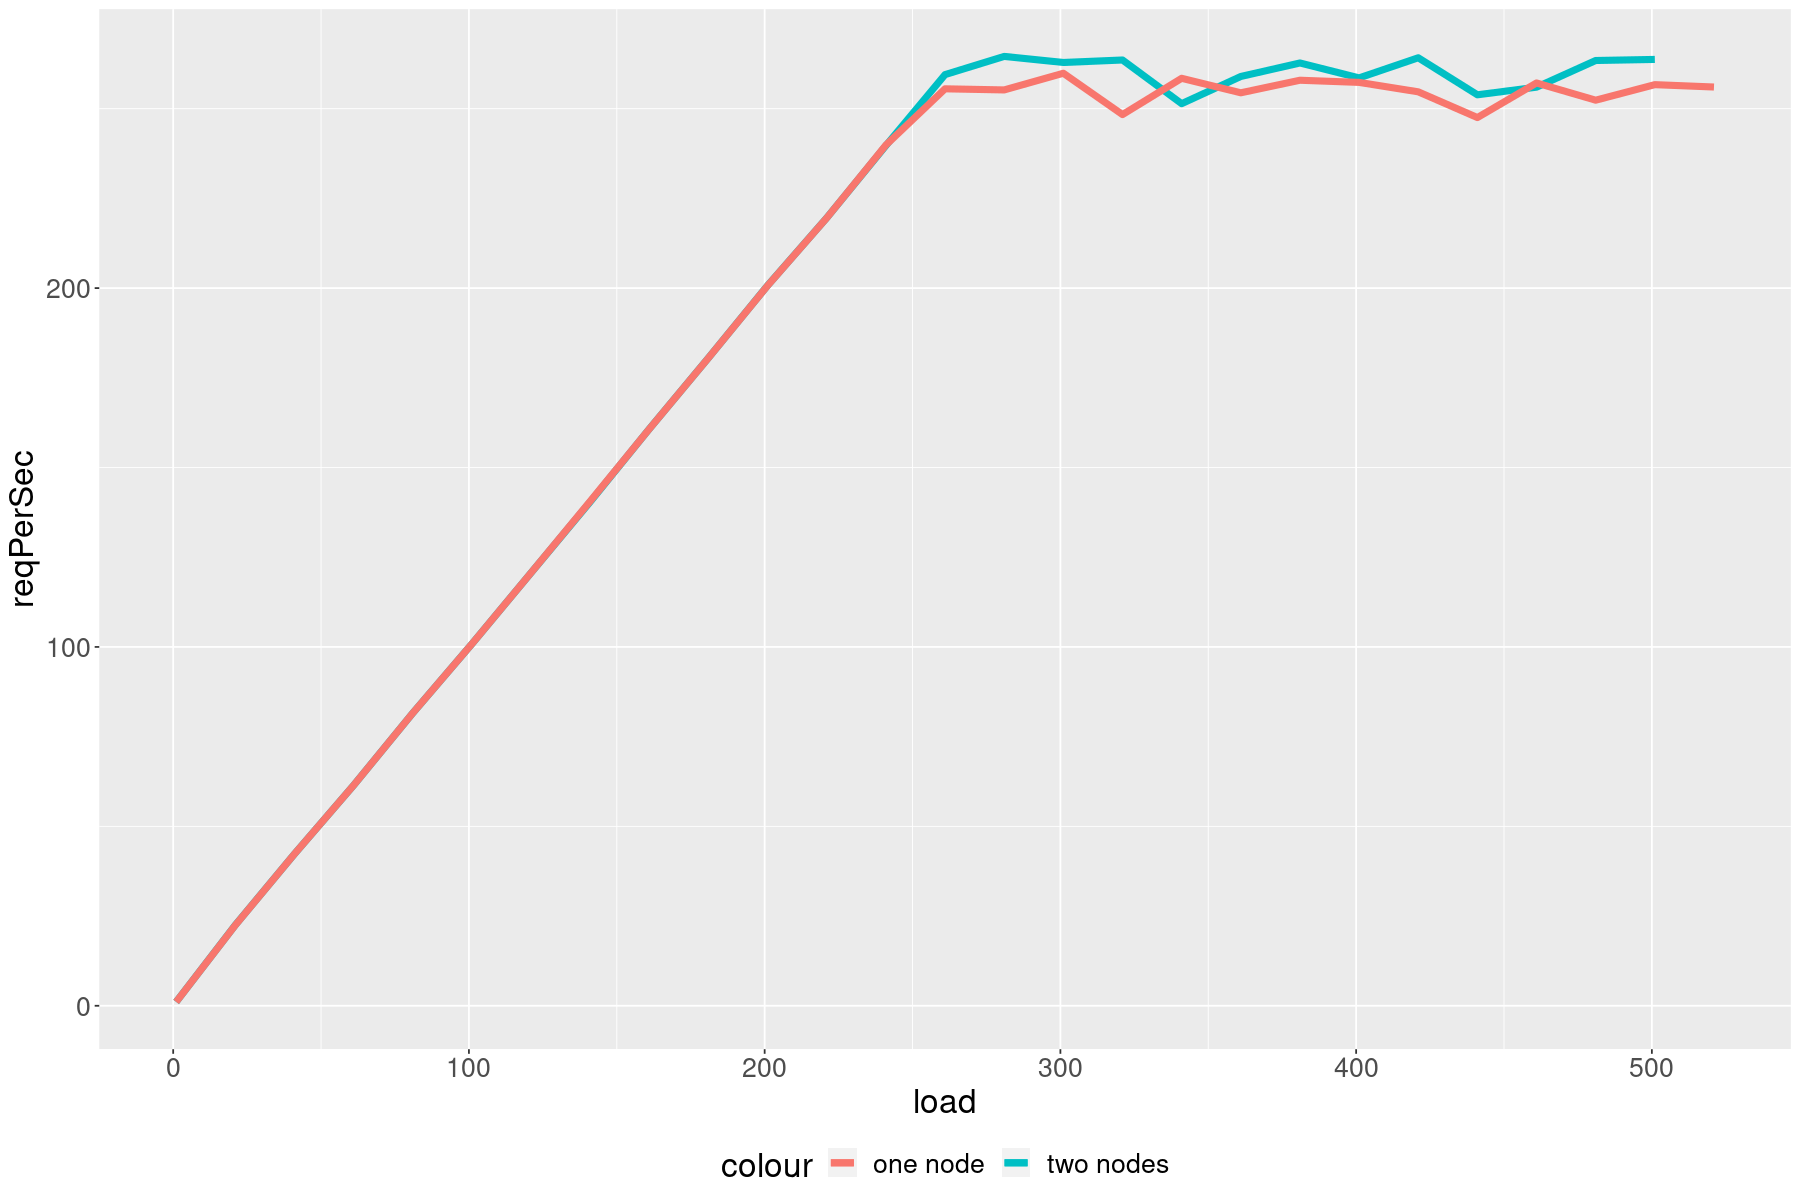

In [6]:
options(repr.plot.width=15, repr.plot.height=10)
data1c <- as_tibble(read.csv("./results_reprod/dsb/bench100/compose_1c/res.csv"))
data2c <- as_tibble(read.csv("./results_reprod/dsb/bench100/compose_2c/res.csv"))

gc <- ggplot() +
  geom_line(data = data2c, aes(x=load, y=reqPerSec, colour="two nodes"), size=2)+
  geom_line(data = data1c, aes(x=load, y=reqPerSec, colour="one node"), size=2)+
  theme(text = element_text(size = 20),legend.position = "bottom")
plot(gc)


# Second try: add a CPU cap

To transform the previous setup to a setup in which the CPU becomes a bottleneck, we choose to add a CPU cap to the previous setup.

To do it, there are 2 approaches: 

- using a VM and set a cpucap in the VM manager (what I used for now)
- set the cpu limits in the docker-compose file (I don't know why I didn't use this directly, I will have to run in this context again)



## Load dataset

In [18]:
setwd("/home/clem/Code/github.com/klementc/internship_simgrid/build/examples/")

datasg <- as_tibble(read.csv("./resComplete.csv"))

#datarw <- as_tibble(read.csv("/home/clem/VirtualBox VMs/shared_folder/resMerge.csv"))
datarw <- as_tibble(read.csv("/home/clem/VirtualBox VMs/shared_folder/sampled_exec/resTot.csv"))
datarw <- datarw %>% 
  mutate(nbn = ifelse(as.character(nbn) == "12", "2", as.character(nbn)))


## Compare throughputs

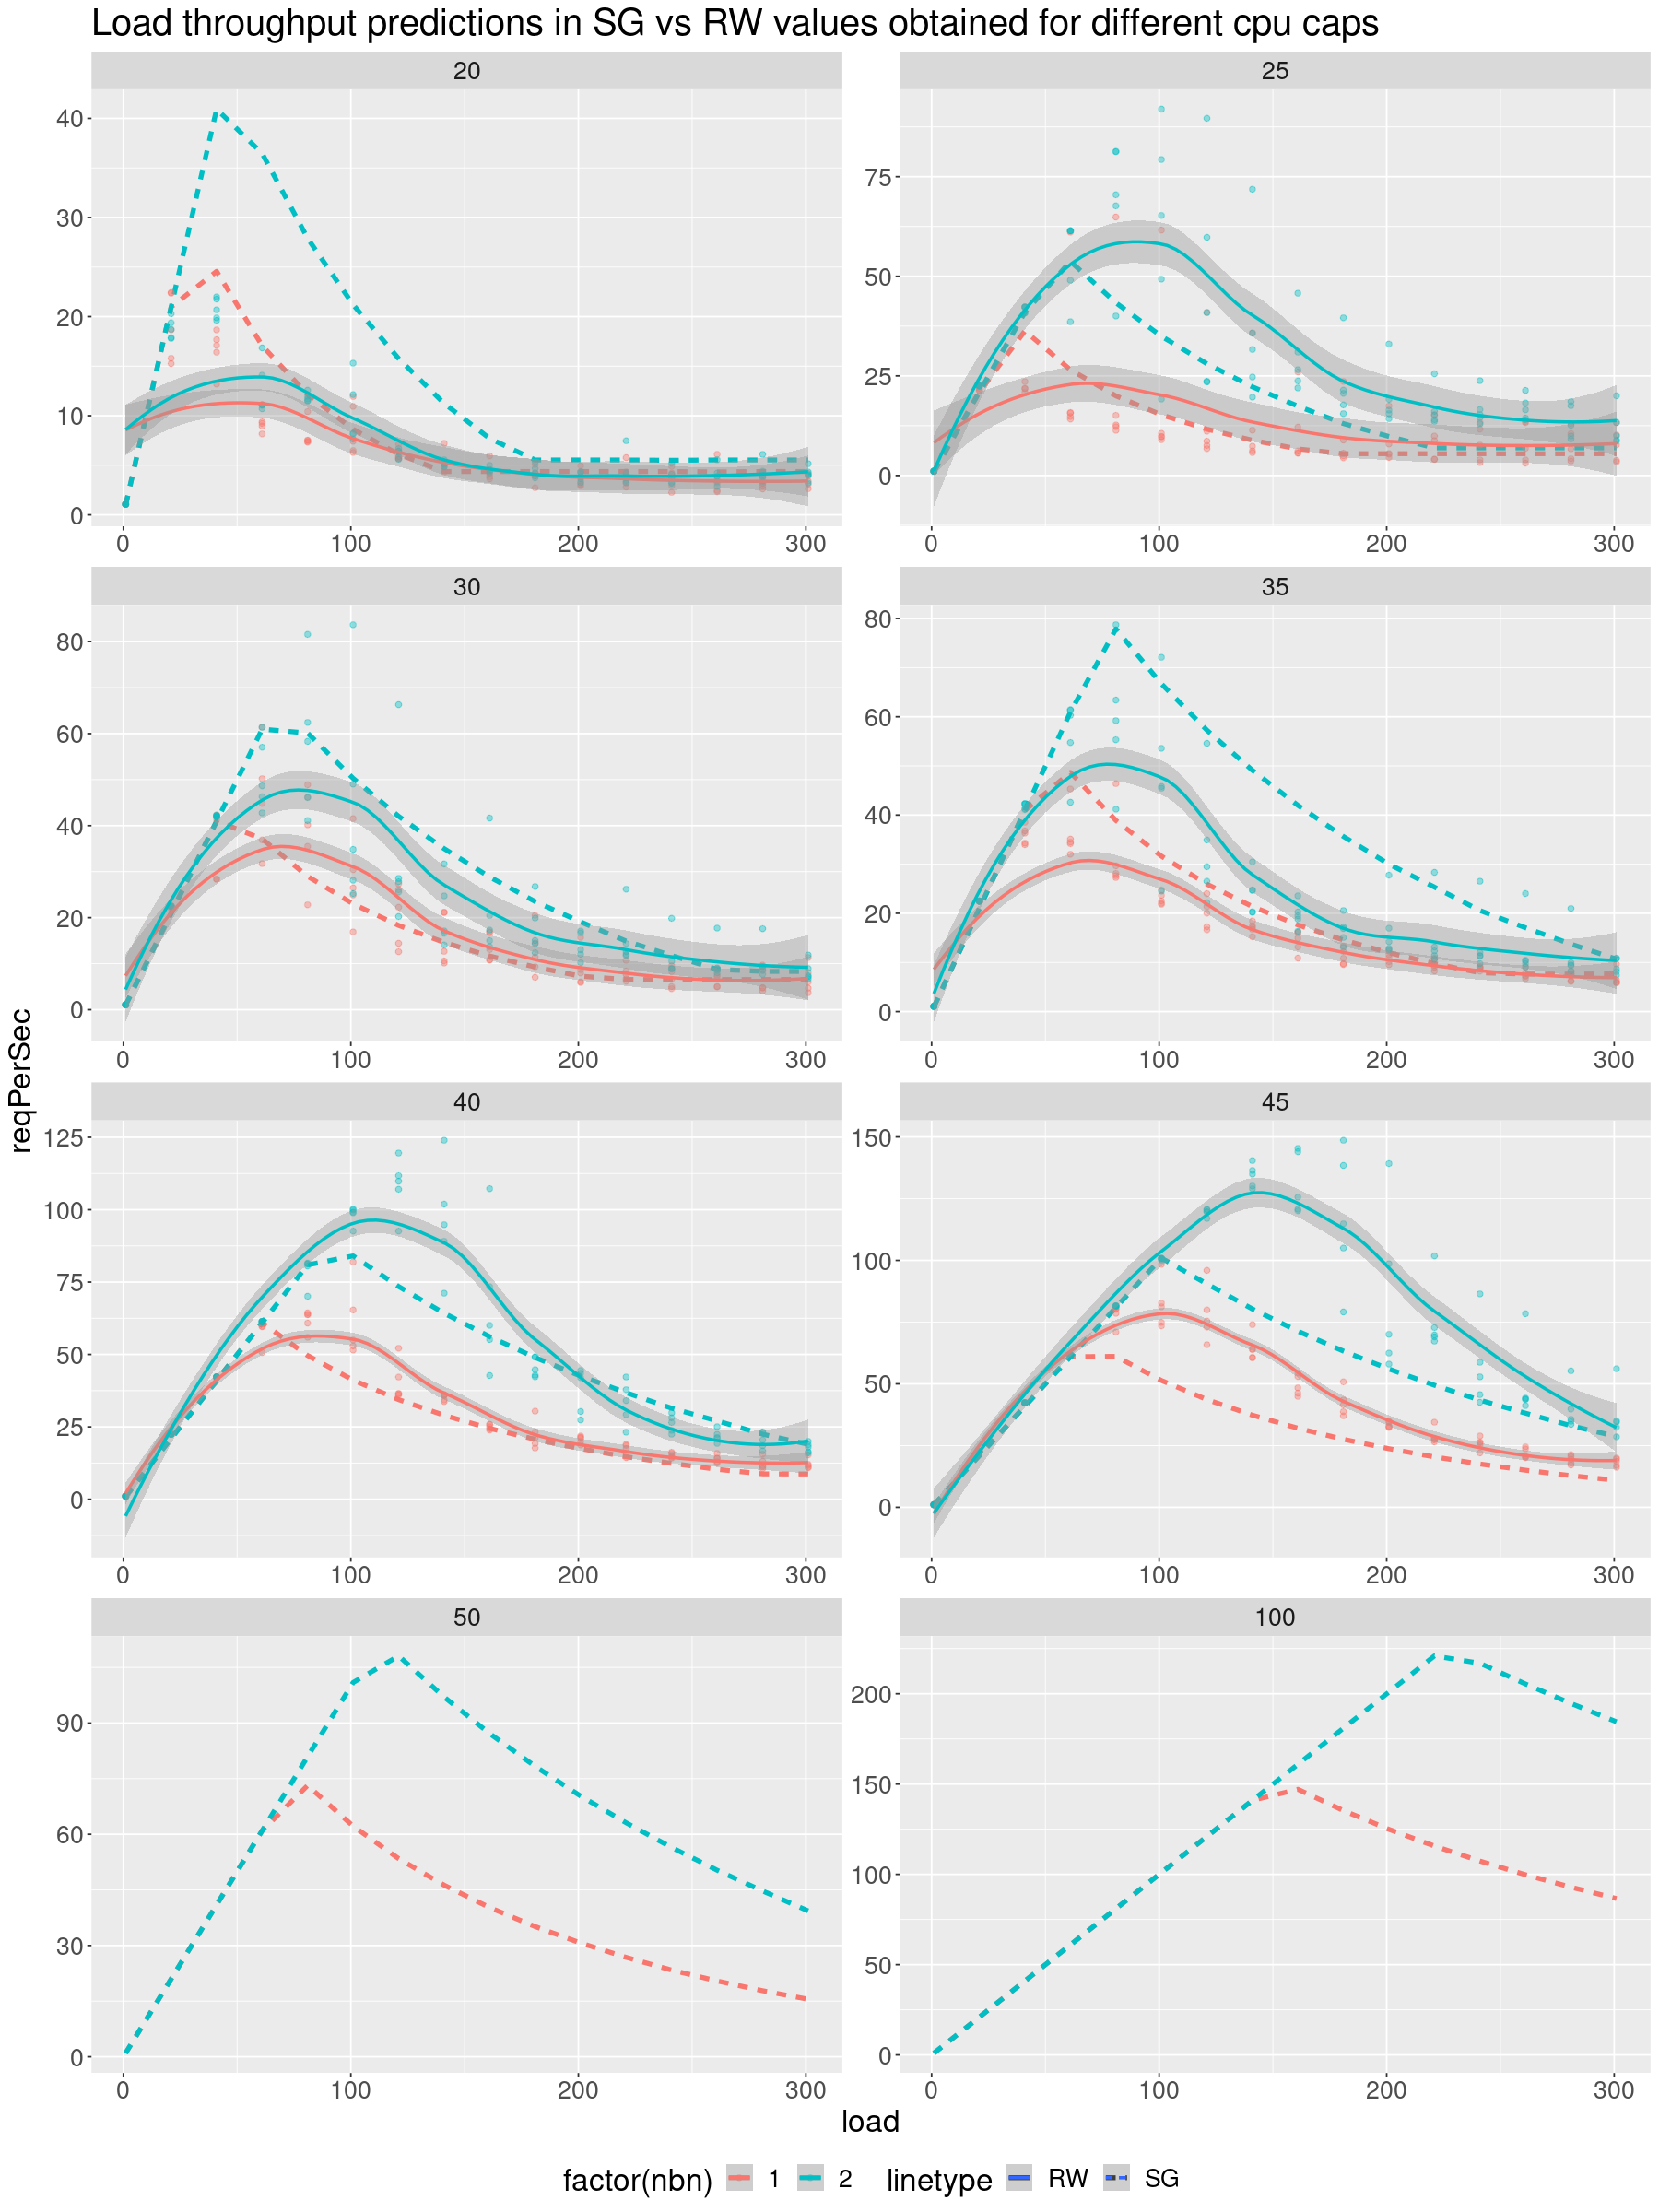

In [19]:
options(repr.plot.width=15, repr.plot.height=20)
gc <- ggplot() +
  geom_line(data = datasg, aes(x=load, y=reqPerSec, group=nbn, colour=factor(nbn), linetype="SG"),size=1.5)+
  geom_point(data = datarw, aes(x=load, y=reqPerSec, group=nbn, colour=factor(nbn)),alpha=.4)+
  geom_smooth(method="loess", data = datarw, formula=y~x, aes(x=load, y=reqPerSec, colour=factor(nbn), linetype="RW"),level=.95)+
  #scale_linetype_manual(values = c("solid","dashed"), labels = c("RW", "SG"))+
  theme(text = element_text(size = 20), legend.position = "bottom")+facet_wrap("perc" ,scale="free", ncol=2)+
  ggtitle("Load throughput predictions in SG vs RW values obtained for different cpu caps")
plot(gc)

From these plots we can comment many things:

- On all of the plots, we observe the 2 nodes setup is predicted to be more efficient than the 1 node setup given its higher maximum throughput whatever the CPU cap.
- On the Real World data observed, we can see that the 2 nodes setup is indeed allowing higher maximum throughput
- We can observe however some differences between SimGrid data and Real World values:
 - on the 20% plot: even though we can see that the 2 nodes setup is better than 1, there is a huge gap between the maximum predicted throughput and the real throughput observed. It seems that with such an important cap, the overheads don't allow for the application to run correctly.
 - After a limit, we observe that SimGrids predictions are more pessimistic than what is obtained in the real world. The maximum difference being with the 100% cap. This can be seen as a consequence of I/Os and similar being counted as CPU usage in SimGrid, because we currently only perform execution. If DSB was only CPU intensive, our predictions would fit, as in the case of bigger caps (see 25 to 45%)

# Powerful CPU experiment

Same idea, but this time on g5k nodes. I cannot execute with all 32 cores because at this rate, it seems to lead to a connection bottleneck due to thrift that don't allow for more requests (https://github.com/delimitrou/DeathStarBench/issues/60).

We run the experiment using full cpu cores (in contrast to the previous results which were for very limited hardware). This time let's look at the latency of requests under different amounts of CPU.

Warning message in eval(expr, envir, enclos):
“NAs introduced by coercion”


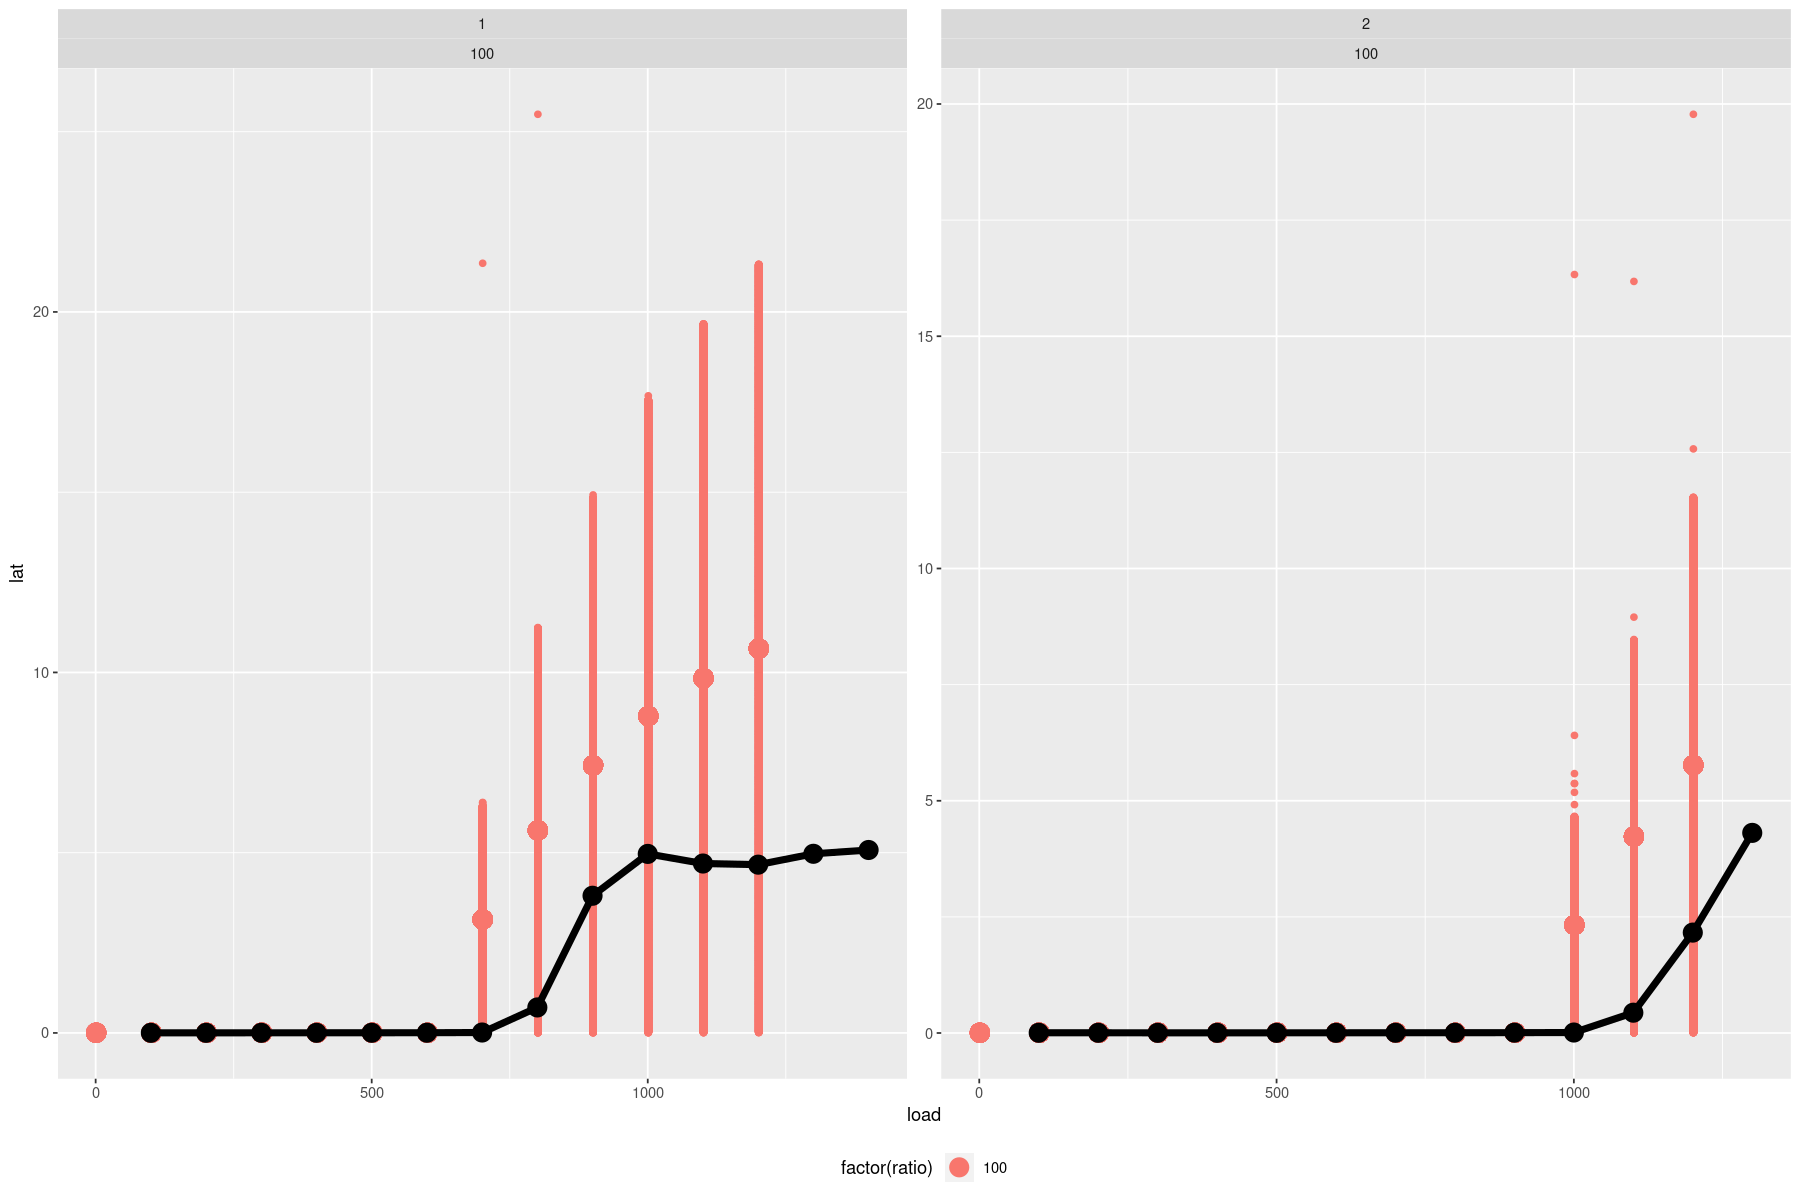

In [31]:
options(repr.plot.width=15, repr.plot.height=10)
#datasg <- as_tibble(read.csv("./reslat3004.csv"))
datasg <- as_tibble(read.csv("/home/clem/Code/github.com/klementc/internship_simgrid/build/examples/reslat0505_4c.csv"))
datarw <- as_tibble(read.csv("/home/clem/logs_expe/bcpdsb/DeathStarBench/socialNetwork/res0504_2/resTot.csv"))

#datasg <- as_tibble(read.csv("./reslat0505_4c.csv"))

datarw4 <- datarw[datarw$nbC %in% 4,] 
datarw4$lat <- datarw4$meanLat / 1000
datasg$lat <- as.numeric(datasg$lat)
datasg <- datasg %>% drop_na(lat)
datasg <- datasg %>% 
  group_by(nbn, load) %>% 
  mutate(meanLat = mean(lat))

gc <- ggplot() +
  geom_point(data = datasg, aes(x=load, y=lat, colour=factor(ratio)),size=1.5)+
  geom_point(data = datasg, aes(x=load, y=meanLat, colour=factor(ratio)),size=5)+
  geom_line(data=datarw4, aes(x=load, y=lat), size=2)+
  geom_point(data = datarw4, aes(x=load, y=lat),size=5)+
  facet_wrap(nbn~ratio, scale="free")+
  theme(legend.position = "bottom")
plot(gc)


Warning message in eval(expr, envir, enclos):
“NAs introduced by coercion”


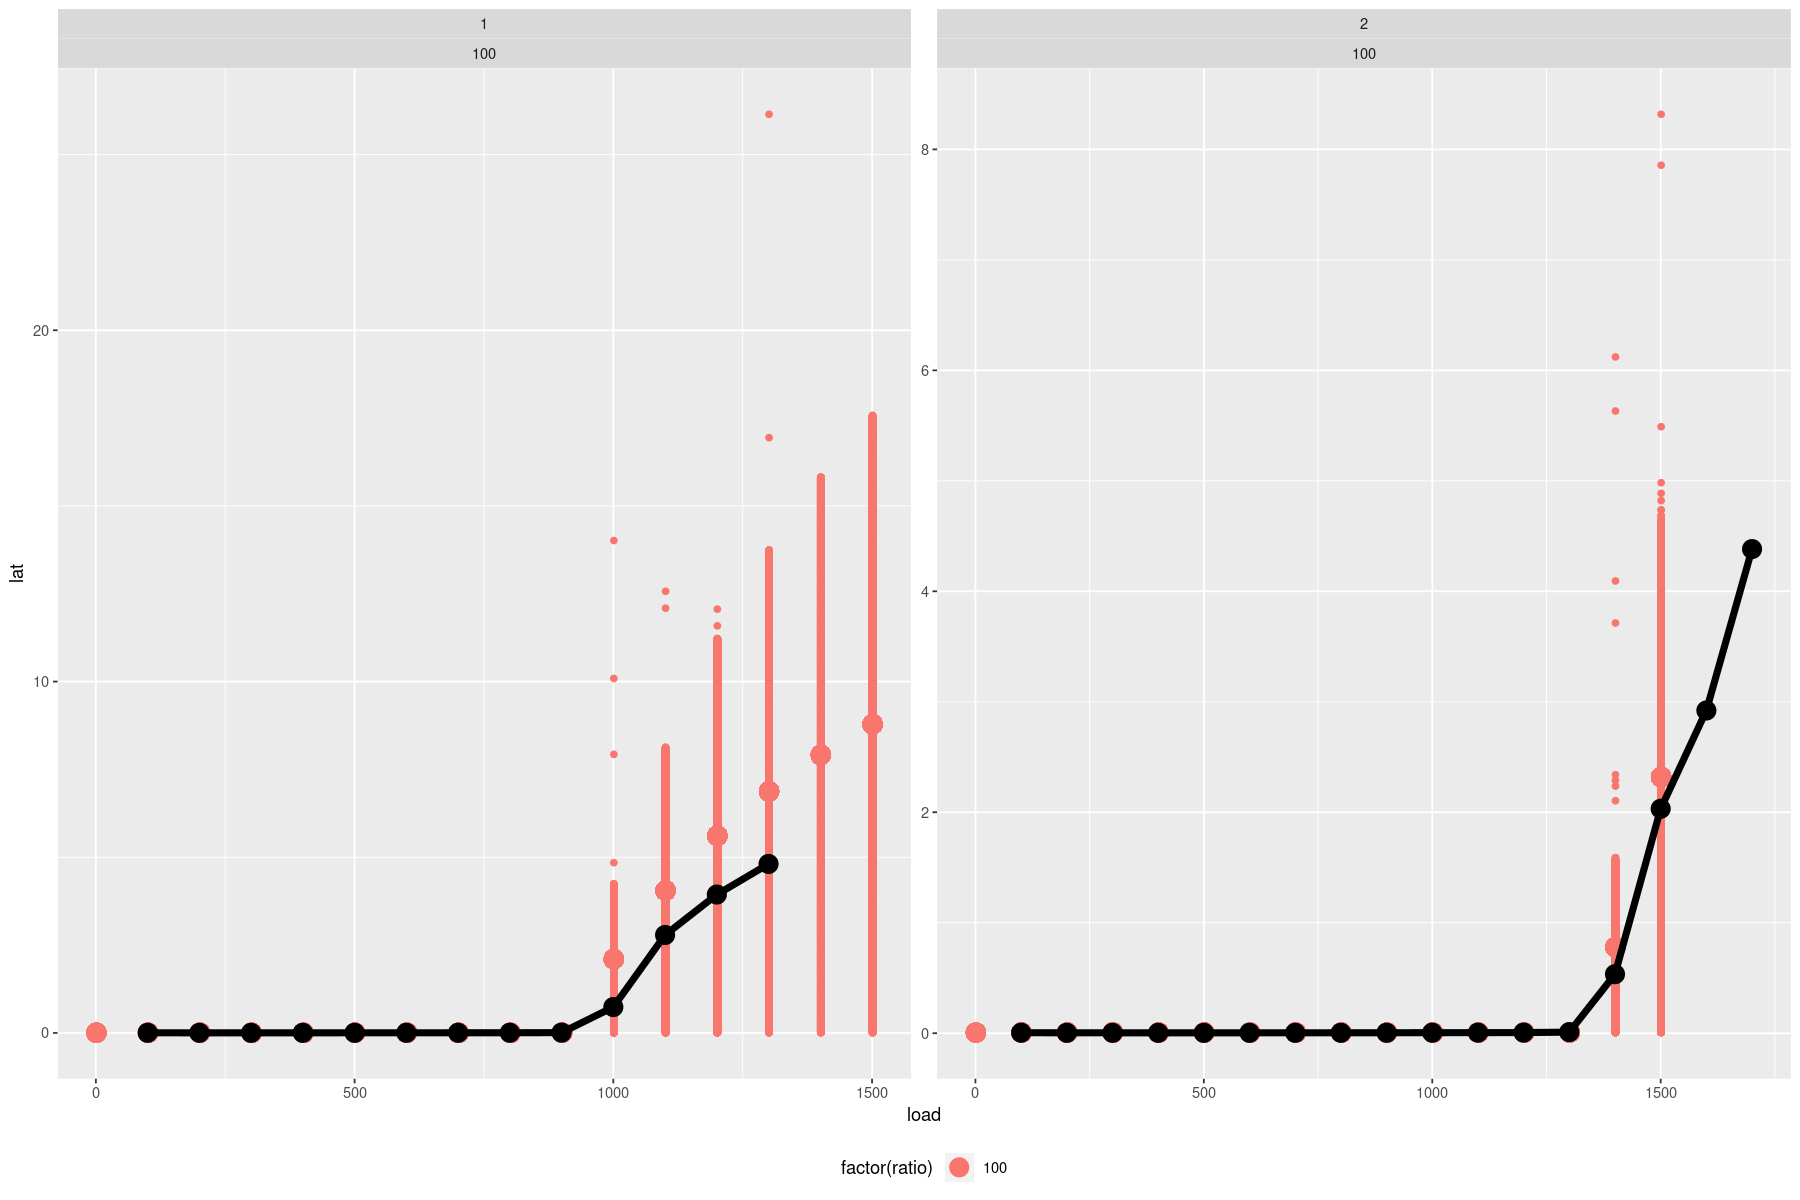

In [29]:
options(repr.plot.width=15, repr.plot.height=10)
datasg <- as_tibble(read.csv("/home/clem/Code/github.com/klementc/internship_simgrid/build/examples/reslat0505_6c.csv"))

datarw6 <- datarw[datarw$nbC %in% 6,] 
datarw6$lat <- datarw6$meanLat / 1000
datasg$lat <- as.numeric(datasg$lat)
datasg <- datasg %>% drop_na(lat)
datasg <- datasg %>% 
  group_by(nbn, load) %>% 
  mutate(meanLat = mean(lat))

gc <- ggplot() +
  geom_point(data = datasg, aes(x=load, y=lat, colour=factor(ratio)),size=1.5)+
  geom_point(data = datasg, aes(x=load, y=meanLat, colour=factor(ratio)),size=5)+
  geom_line(data=datarw6, aes(x=load, y=lat), size=2)+
  geom_point(data = datarw6, aes(x=load, y=lat),size=5)+
  facet_wrap(nbn~ratio, scale="free")+
  theme(legend.position = "bottom")
plot(gc)

Warning message in eval(expr, envir, enclos):
“NAs introduced by coercion”


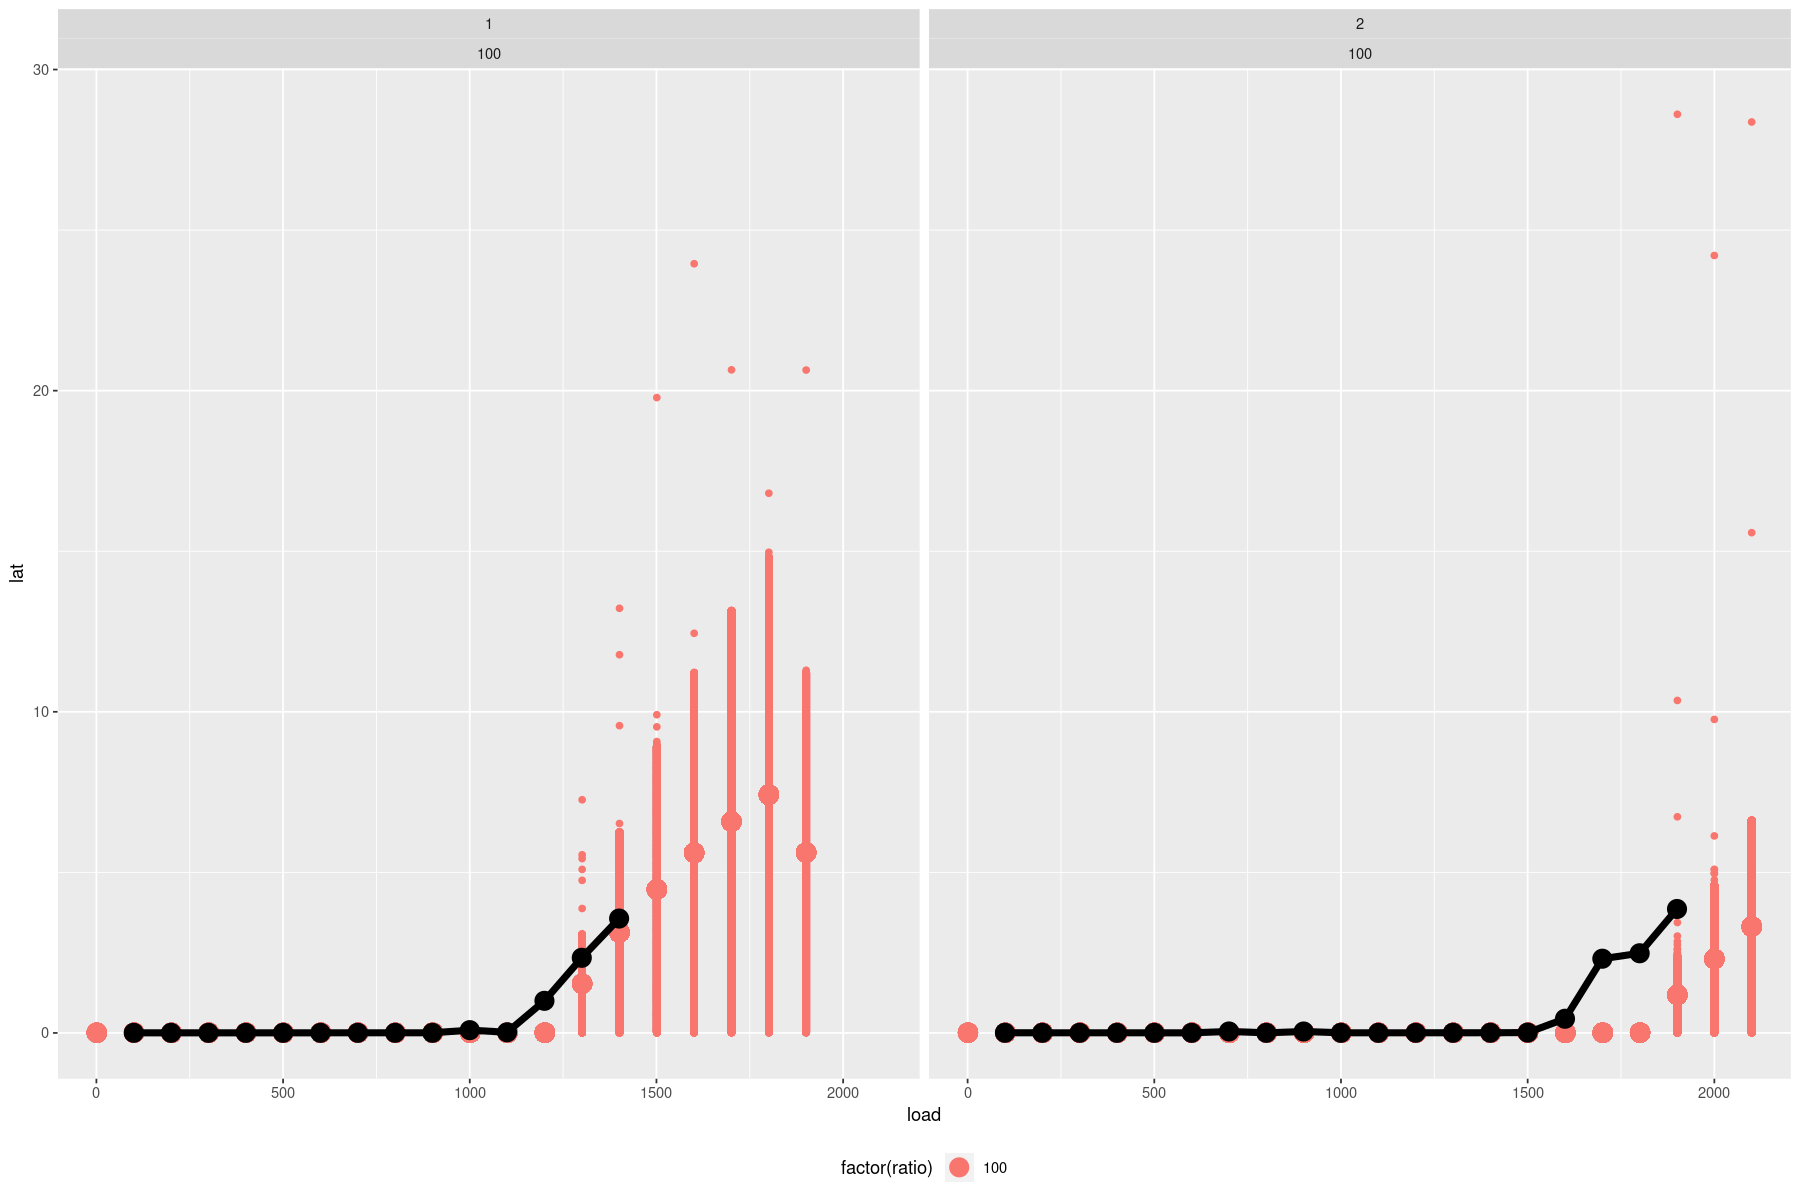

In [32]:
options(repr.plot.width=15, repr.plot.height=10)
datasg <- as_tibble(read.csv("/home/clem/Code/github.com/klementc/internship_simgrid/build/examples/reslat0505_8c.csv"))

datarw <- as_tibble(read.csv("/home/clem/logs_expe/bcpdsb/DeathStarBench/socialNetwork/res0504_2/resTot.csv"))

datarw8 <- datarw[datarw$nbC %in% 8,] 
datarw8$lat <- datarw8$meanLat / 1000
datasg$lat <- as.numeric(datasg$lat)
datasg <- datasg %>% drop_na(lat)
datasg <- datasg %>% 
  group_by(nbn, load) %>% 
  mutate(meanLat = mean(lat))

gc <- ggplot() +
  geom_point(data = datasg, aes(x=load, y=lat, colour=factor(ratio)),size=1.5)+
  geom_point(data = datasg, aes(x=load, y=meanLat, colour=factor(ratio)),size=5)+
  geom_line(data=datarw8, aes(x=load, y=lat), size=2)+
  geom_point(data = datarw8, aes(x=load, y=lat),size=5)+
  facet_wrap(nbn~ratio)+
  theme(legend.position = "bottom")
plot(gc)
